## Compare epigenetic marks with current TSS (and putative peaks)
marks taken from http://cho-epigenome.boku.ac.at/

In [1]:
## Parameters specific to where your folders are and your data
parameter_file = '../params/params.yaml'
import yaml
import sys

with open(parameter_file,'r') as f:
    doc = yaml.load(f)

#p = dic2obj(**doc)

data_folder = doc['data_folder']
tissues = doc['tissues'].split(',')
sys.path.append(doc['pipeline_path'])
ref_fa = doc['ref_fa']
anno_gff=doc['annotation']
mRNA_peak_file = doc["mRNA_peak_file"]
tss_annotation = doc['tss_annotation']
supplemental = doc["supplemental"]

import os

import subprocess
import sys
import pandas as pd
import matplotlib
import seaborn as sns
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from itertools import product
import glob
import re
from matplotlib_venn import venn2
from matplotlib import rcParams
import inspect
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sys.setrecursionlimit(3000)
%load_ext autoreload
%autoreload 2
rcParams['figure.figsize'] = 8, 6
import tqdm

from os.path import basename
from os.path import join
##mpl.use('Agg')
#mpl.style.use('ggplot')
#mpl.style.use('fivethirtyeight')
from Homer import *
import helper
import create_output
print('Number of tissues: ',len(tissues))
import Homer
import re

/home/isshamie/software/anaconda2/envs/TSS/lib/python3.7/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


Number of tissues:  13


### Output files and directories


In [2]:
chrom_dir = "Results/chromHMM_overlap"
if not os.path.exists(chrom_dir):
    os.mkdir(chrom_dir)
    
tss_1bp_bed_f = join(chrom_dir, "TSS_exp.1bp.bed")
tss_overlap_dir = join(chrom_dir, "TSS_overlap_dir")
if not os.path.exists(tss_overlap_dir):
    os.mkdir(tss_overlap_dir)

    
rtss_1bp_bed_f = join(chrom_dir, "rTSS.1bp.bed")
rtss_overlap_dir = join(chrom_dir, "rTSS_overlap_dir")
if not os.path.exists(rtss_overlap_dir):
    os.mkdir(rtss_overlap_dir)

states_dir = join(chrom_dir, "states_dir")
if not os.path.exists(states_dir):
    os.mkdir(states_dir)

CHO_exp_bed_f = join(chrom_dir,"sample_CHO_GROCap1_and_CHO_GRO1.bed")
CHO_1bp_exp_bed_f = join(chrom_dir,"sample_CHO_GROCap1_and_CHO_GRO1.1bp.bed")
cho_overlap_dir = join(chrom_dir, "CHO_overlap_dir")
if not os.path.exists(cho_overlap_dir):
    os.mkdir(cho_overlap_dir)

### Input

#### HMM results

In [3]:
chromHMM_dir = join(supplemental, "epigenome", "PRJEB9291","chromHMM_results")
hmm_files = glob.glob(chromHMM_dir+"/*.bed")
states_map = pd.read_csv(join(chromHMM_dir, "marks.csv"),header=None)

states_map_dict = {val[0]:re.sub("\)","",re.sub(" \(*","_",val[1])) for _,val in states_map.iterrows()}


In [4]:
states_map_dict

{1: 'Polycomb_repressed_regions',
 2: 'Quiescent',
 3: 'Repressed_heterochromatin',
 4: 'Strong_transcription',
 5: 'Weak_genic_enhancer',
 6: 'Weak_enhancer',
 7: 'Active_enhancer_1',
 8: 'Active_enhancer_2',
 9: 'Active_promoter',
 10: 'Flanking_TSS_upstream',
 11: 'Flanking_TSS_downstream'}

#### Only using Tp0 

In [5]:
curr_hmm_f = join(chromHMM_dir, 'Tp0_11_all_dense.bed')

#### TSS results

In [6]:
TSS_exp_bed_f = "../Results/output/TSS1.exp.bed"
rTSS_bed_f = "Results/homer_motifs/TSS1.exp_refseq_centered.narrow.bed"
CHO_exp_pos_f = "../Results/tss_annotation_peaks/sample_CHO_GROCap1_and_CHO_GRO1.tsv"

In [7]:
def read_chromHMM_bed(f):
    df = pd.read_csv(f, sep="\t", header=None, skiprows=1)
    columns = df.columns.values.astype(str)
    columns[:6] = ["Chr", "Start","End","State","Stat","Strand"]
    df.columns = columns
    return df

In [8]:
curr_hmm = read_chromHMM_bed(curr_hmm_f)

#### Check if chromosomes are covered in genome

In [9]:
chromosomes = curr_hmm["Chr"].unique()
chromosomes_ref = pd.read_csv('Results/genome/chrom.sizes',sep="\t", header=None)[0].unique()
chrom_not_in_mrna = set()
for chrom in chromosomes:
    if chrom not in chromosomes_ref:
        chrom_not_in_mrna.add(chrom)
        print(chrom)
print(f"Number of missing chromosomes: {len(chrom_not_in_mrna)}")

Number of missing chromosomes: 0


## Look at overlap bed 

### Steps:
- A. For TSS files, make sure only one basepair. For the sample peaks, need to convert to bed first
- B. Split up chromHMM into separate bed files for each state
- C. Bedtools intersect for each of them
- D. Read number of lines for each and construct vector of nStates where each value is TSS %, which is just number of lines in the intersection file


#### Convert the CHO position to bed

In [10]:
# cmd = f"pos2bed.pl {CHO_exp_pos_f} -o {CHO_exp_bed_f}"
# print(cmd)
# #os.system(cmd)

Homer.peak_to_bed(CHO_exp_pos_f,CHO_exp_bed_f)

pos2bed.pl ../Results/tss_annotation_peaks/sample_CHO_GROCap1_and_CHO_GRO1.tsv > Results/chromHMM_overlap/sample_CHO_GROCap1_and_CHO_GRO1.bed.tmp
tail -n +2 < Results/chromHMM_overlap/sample_CHO_GROCap1_and_CHO_GRO1.bed.tmp > Results/chromHMM_overlap/sample_CHO_GROCap1_and_CHO_GRO1.bed


###  Make TSS a Single basepair 

In [11]:
def create_single_bp(in_f,out_f):
    bed_df = read_bed_file(in_f)
    center = (np.floor((bed_df["End"]-bed_df["Start"])/2)).astype(int)
    bed_df_1bp = bed_df.copy()
    bed_df_1bp["Start"] += center
    bed_df_1bp["End"] -= center
    write_bed_file(bed_df_1bp, out_f)
    #Note, only works with odd length distances. Even will not have center
    return

In [12]:
create_single_bp(TSS_exp_bed_f,tss_1bp_bed_f)

In [13]:
create_single_bp(rTSS_bed_f,rtss_1bp_bed_f)

In [14]:
create_single_bp(CHO_exp_bed_f,CHO_1bp_exp_bed_f)

### B.

In [15]:
for ind,val in curr_hmm.groupby("State"):
    val.to_csv(join(states_dir, states_map_dict[ind]+".bed"), sep="\t", header=None, index=None)

In [16]:
cmap = sns.color_palette("Paired",n_colors=len(states_map_dict))

### C.

In [17]:
def run_intersect_states(A, prefix, overlap_dir, states_dir, states_map_dict):
    for ind in states_map_dict:
        B = join(states_dir, states_map_dict[ind]+".bed")
        f_save = f"{prefix}_{states_map_dict[ind]}.bed"
        cmd = f"bedtools intersect -a {A} -b {B} > {join(overlap_dir,f_save)}"
        #print(cmd)
        os.system(cmd)
    return

In [18]:
run_intersect_states(tss_1bp_bed_f, "TSS_intersect", tss_overlap_dir, states_dir, states_map_dict)

In [19]:
run_intersect_states(CHO_1bp_exp_bed_f, "CHO_intersect", cho_overlap_dir, states_dir, states_map_dict)

In [20]:
run_intersect_states(rTSS_bed_f, "rTSS_intersect", rtss_overlap_dir, states_dir, states_map_dict)

## D. 

In [21]:
def create_overlap(bed_f, chrom_dir, out_prefix, overlap_dir, states_map_dict):
    cmd = f"wc -l<{bed_f}" #Total TSS'
    total_tss = int(subprocess.check_output(cmd, shell=True, universal_newlines=True))

    tss_overlap = pd.DataFrame(index=states_map_dict.values(), columns=['State', 'TSS numbers', 'TSS percentage'])
    for ind in states_map_dict:
        f_save = f"{out_prefix}_{states_map_dict[ind]}.bed"
        cmd = f"wc -l <{join(overlap_dir,f_save)}"
        output = subprocess.check_output(cmd, shell=True, universal_newlines=True)
        tss_overlap.at[states_map_dict[ind], 'TSS numbers'] = int(output)
        tss_overlap.at[states_map_dict[ind], 'TSS percentage'] = 100.0*int(output)/total_tss
        tss_overlap.at[states_map_dict[ind], 'State'] = ind


    f=plt.figure()
    tss_overlap.plot.pie(y="TSS percentage", figsize=(15,15),colors=cmap)
    plt.legend(loc='upper right', bbox_to_anchor=(0,0))

    return tss_overlap

<Figure size 576x432 with 0 Axes>

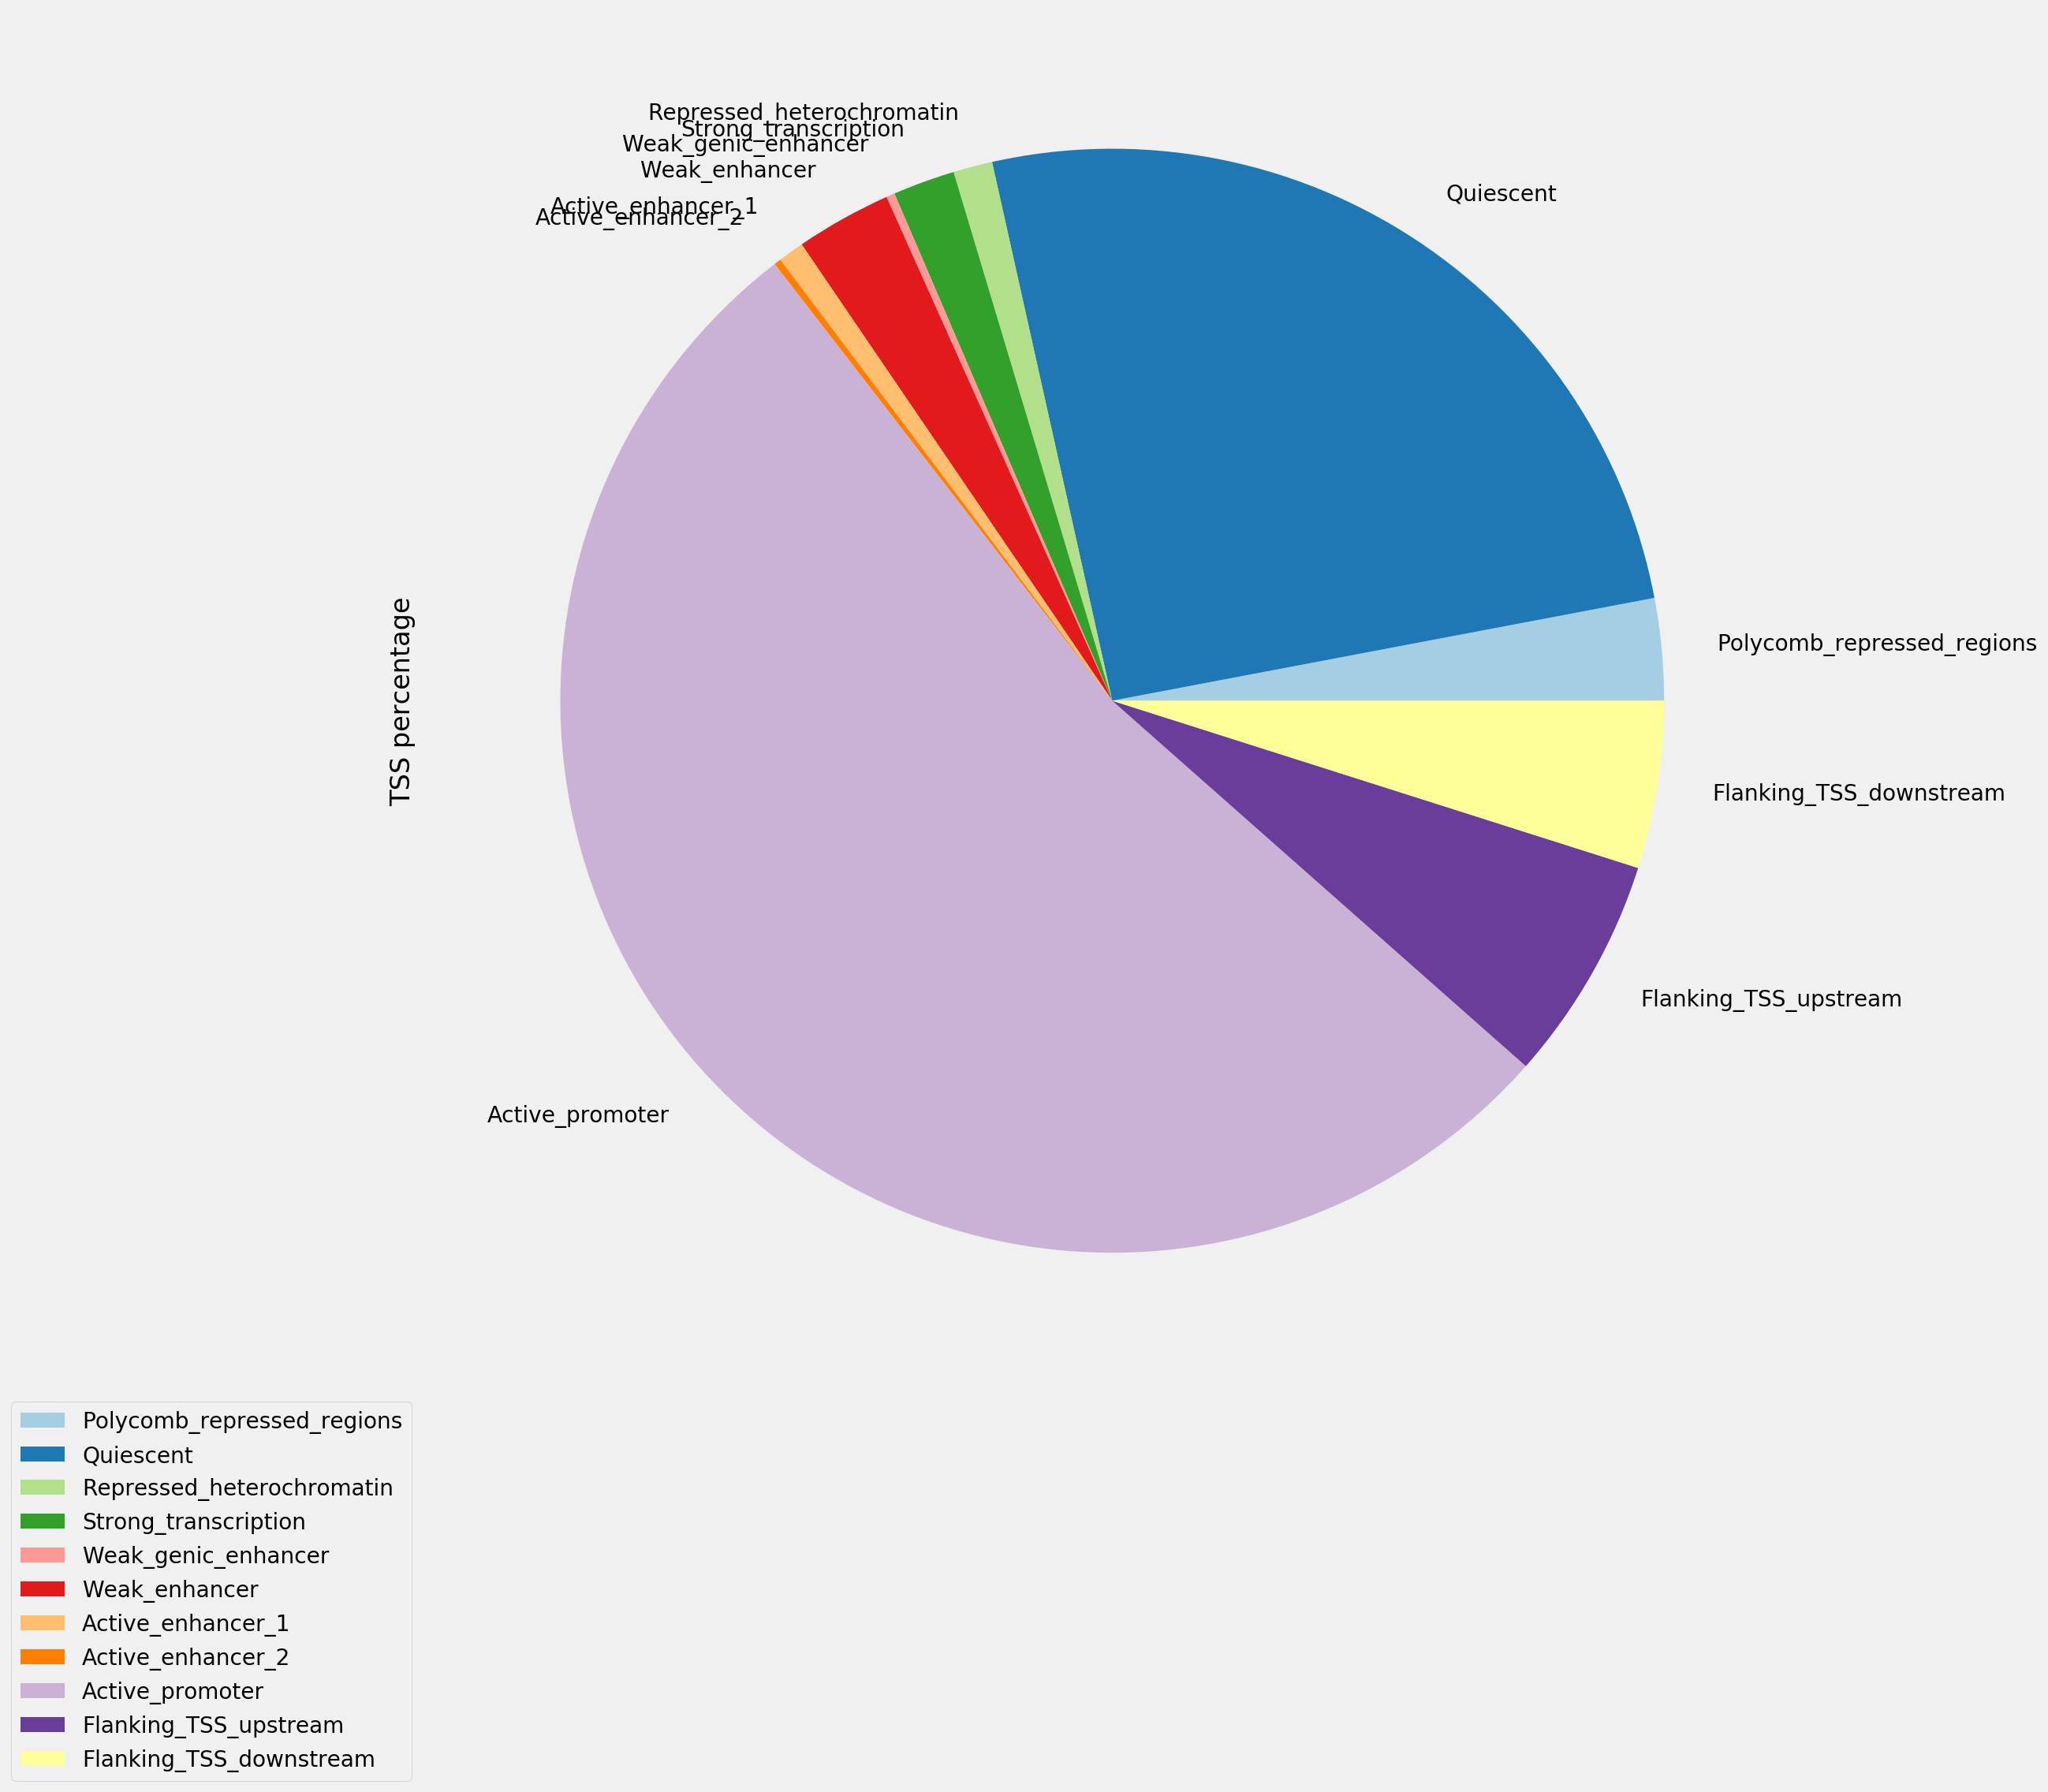

In [22]:
tss_overlap = create_overlap(tss_1bp_bed_f, chrom_dir, "TSS_intersect", tss_overlap_dir, states_map_dict)

<Figure size 576x432 with 0 Axes>

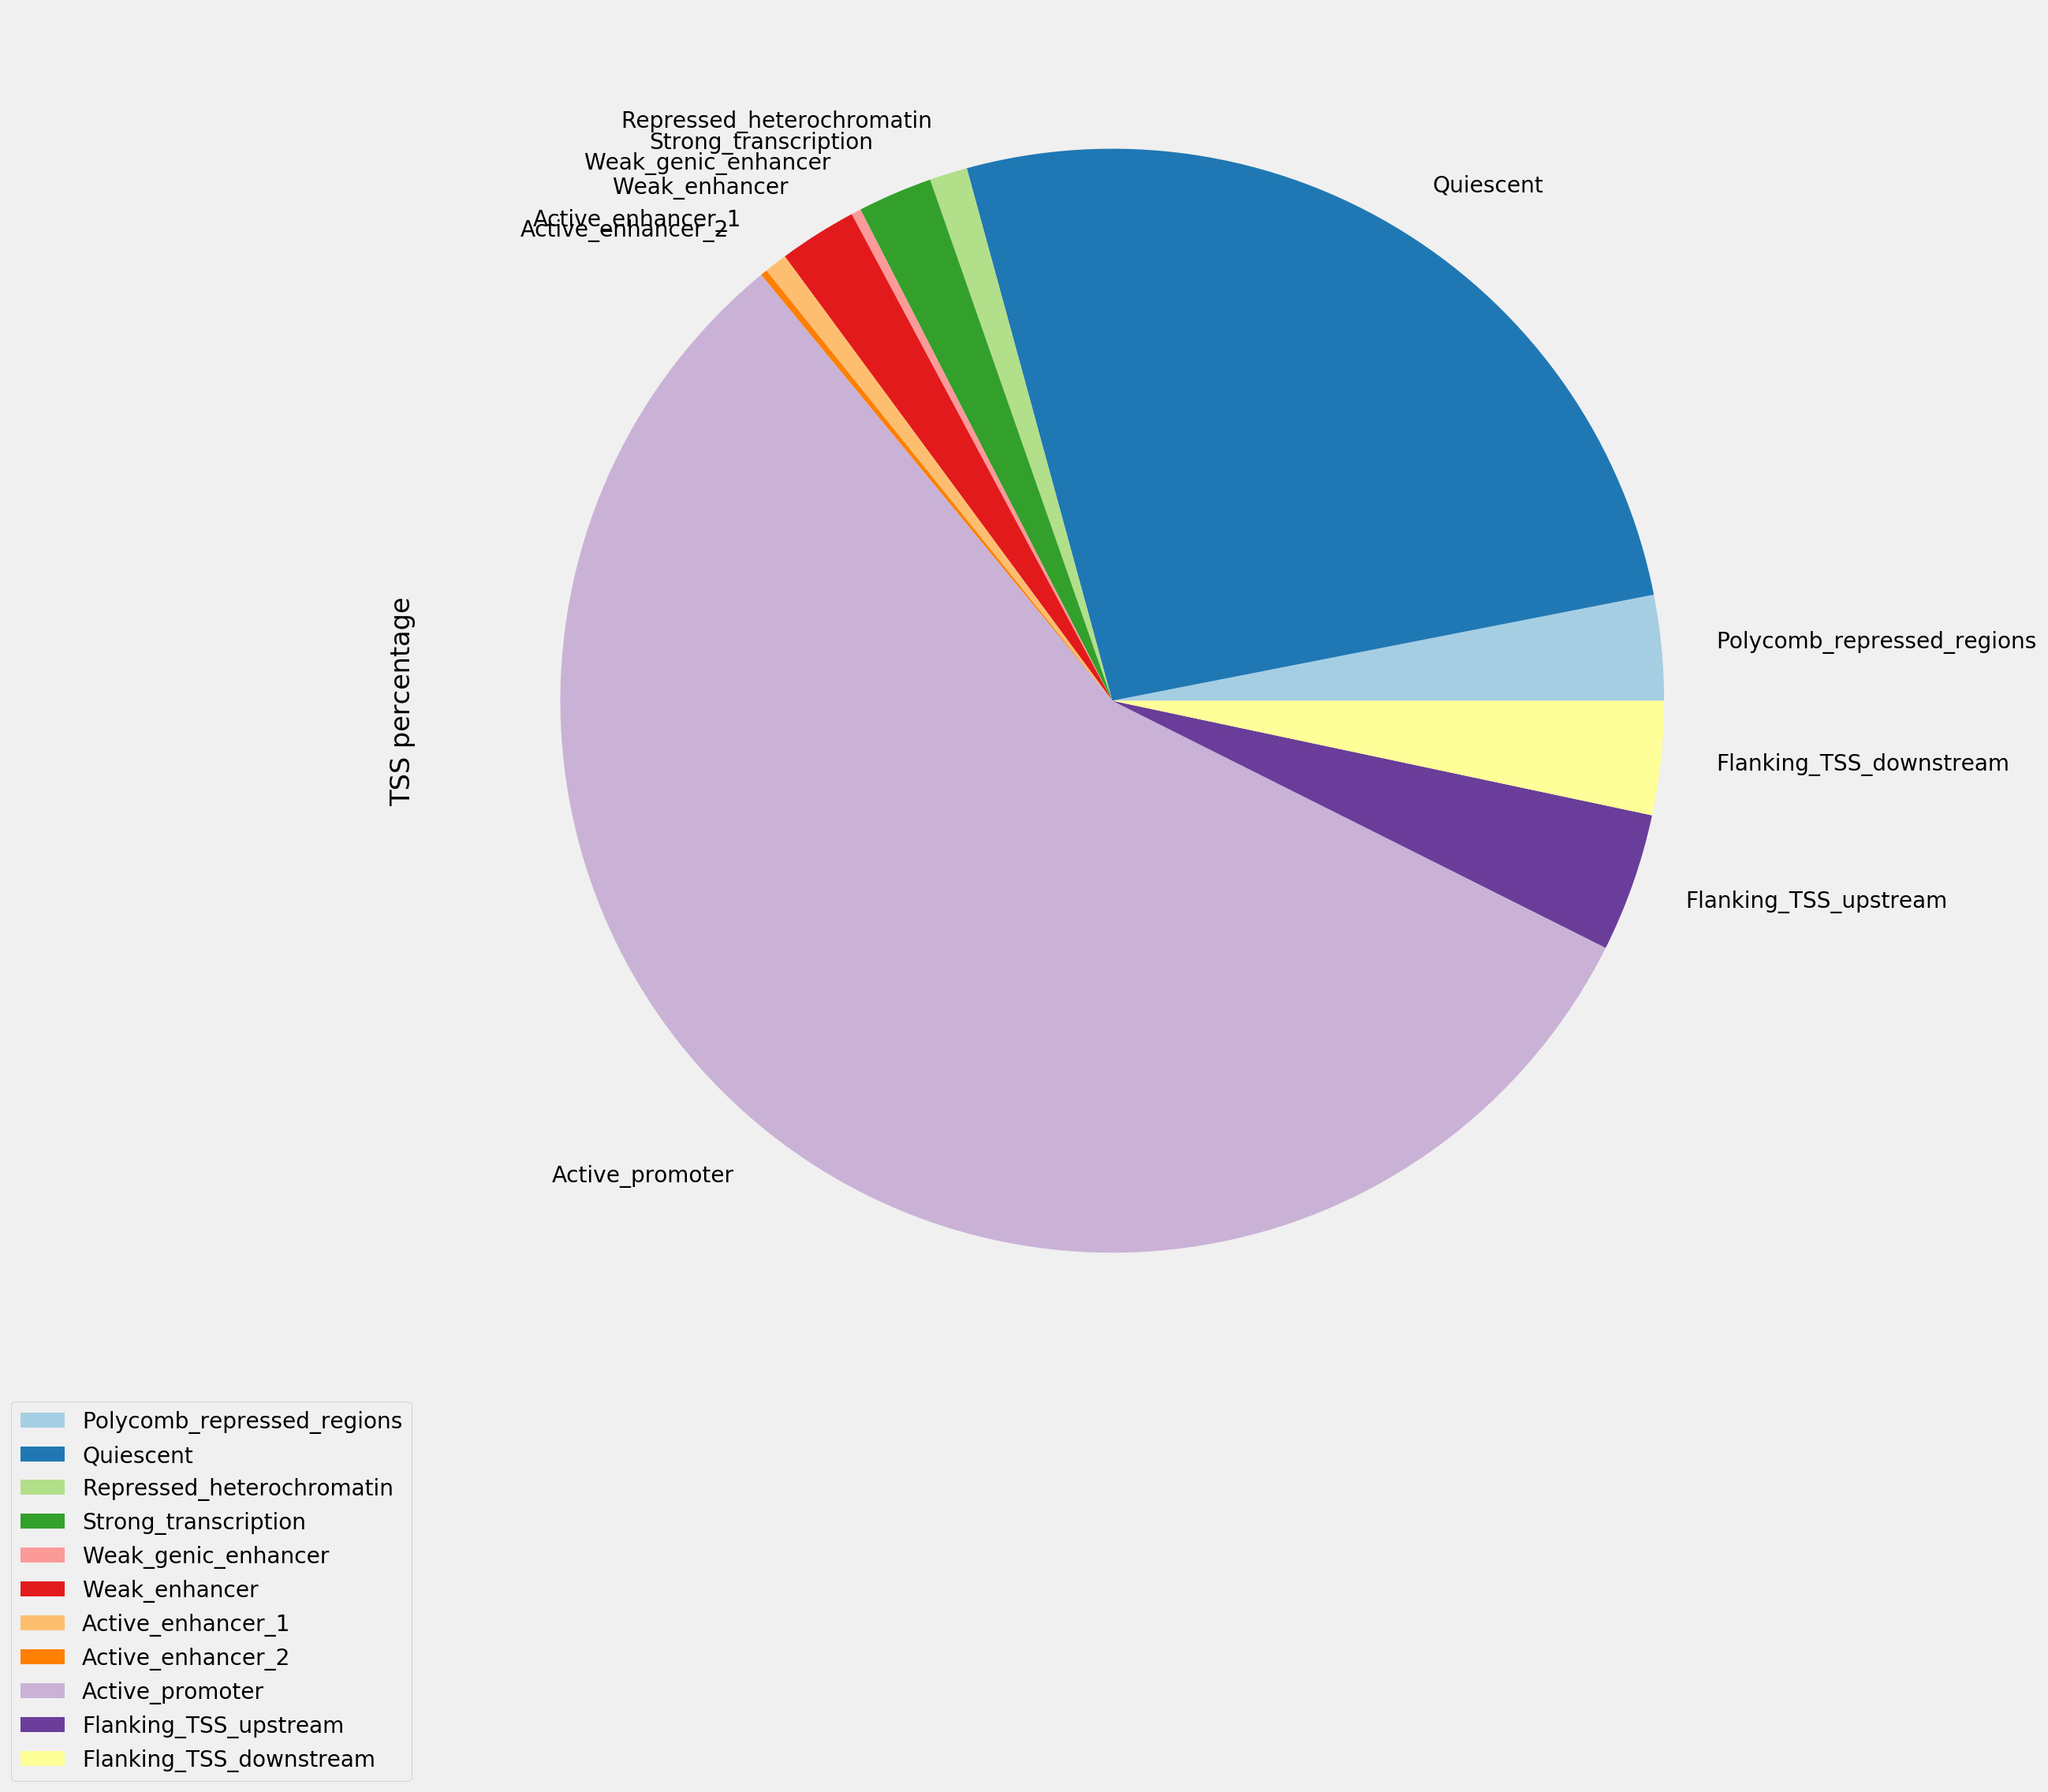

In [23]:
rtss_overlap = create_overlap(rtss_1bp_bed_f, chrom_dir, "rTSS_intersect", rtss_overlap_dir, states_map_dict)

In [24]:
tss_overlap

,State,TSS numbers,TSS percentage
Polycomb_repressed_regions,1,918,2.98294
Quiescent,2,7851,25.511
Repressed_heterochromatin,3,353,1.14703
Strong_transcription,4,559,1.81641
Weak_genic_enhancer,5,76,0.246954
Weak_enhancer,6,864,2.80747
Active_enhancer_1,7,233,0.757108
Active_enhancer_2,8,64,0.207961
Active_promoter,9,16313,53.0073
Flanking_TSS_upstream,10,2036,6.61576


In [25]:
rtss_overlap

,State,TSS numbers,TSS percentage
Polycomb_repressed_regions,1,636,3.08184
Quiescent,2,5407,26.2005
Repressed_heterochromatin,3,229,1.10966
Strong_transcription,4,452,2.19024
Weak_genic_enhancer,5,59,0.285894
Weak_enhancer,6,472,2.28715
Active_enhancer_1,7,138,0.668702
Active_enhancer_2,8,41,0.198672
Active_promoter,9,11703,56.7088
Flanking_TSS_upstream,10,839,4.06551


<Figure size 576x432 with 0 Axes>

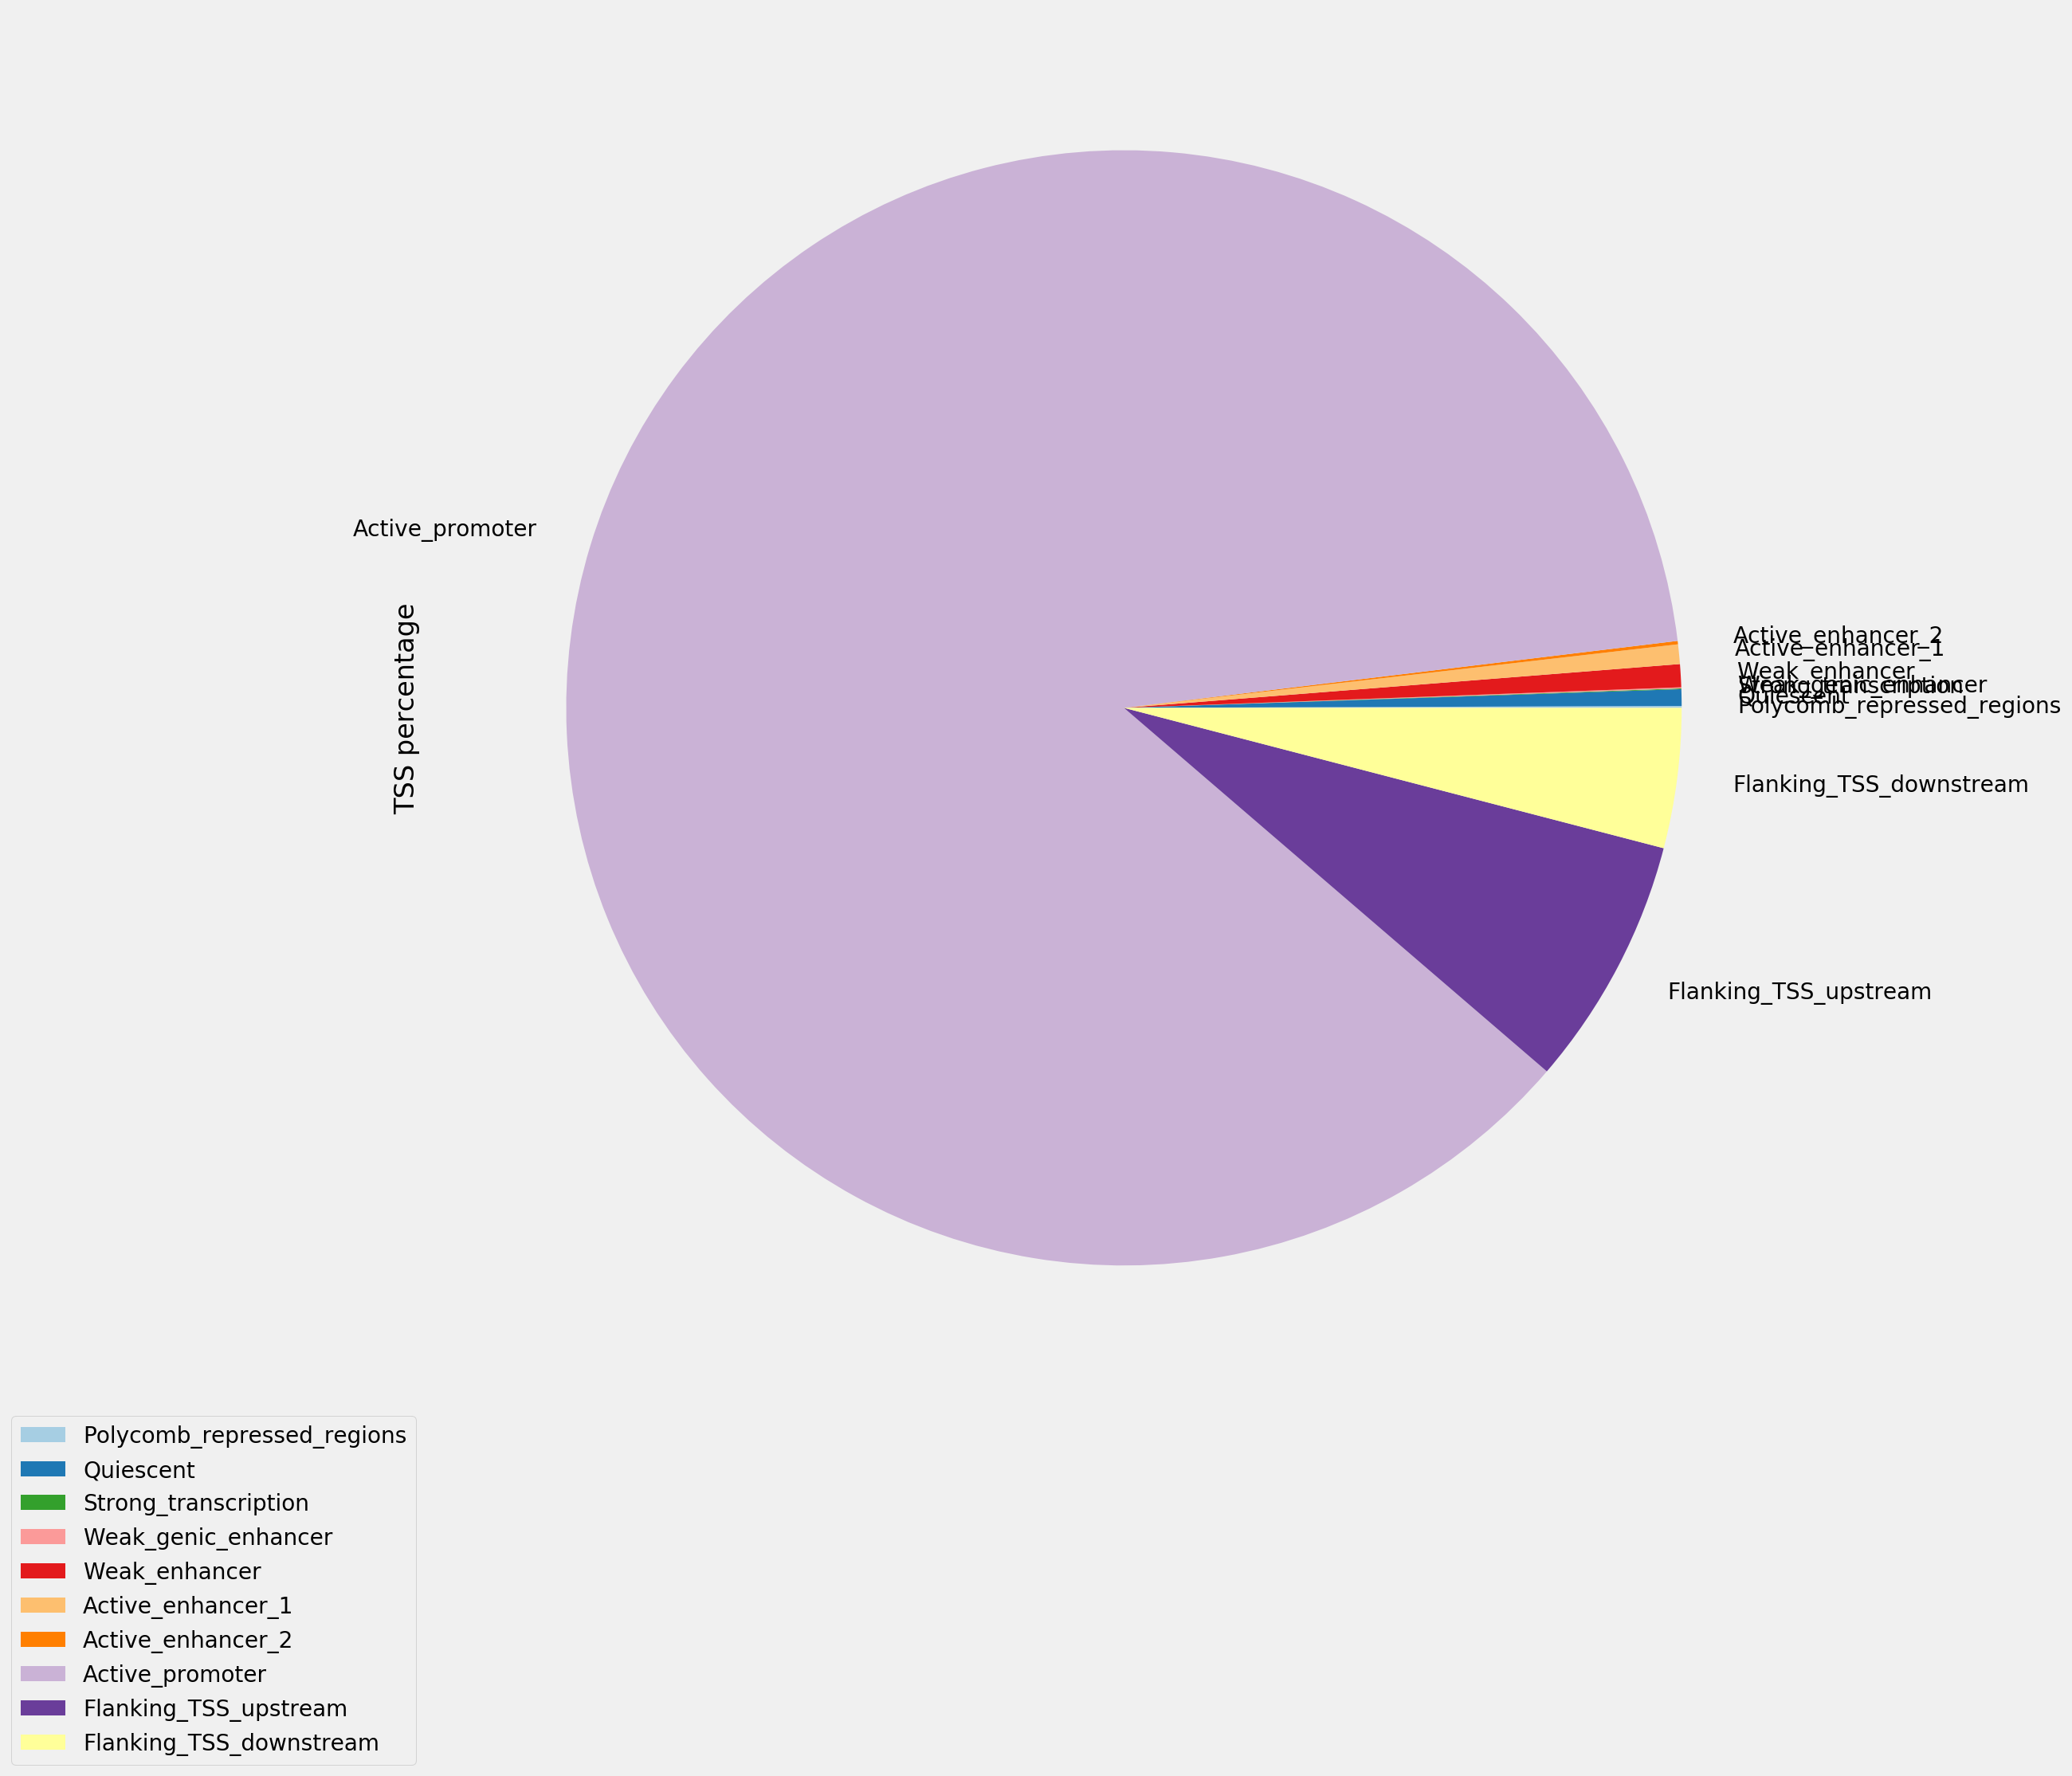

In [26]:
cho_overlap = create_overlap(CHO_1bp_exp_bed_f, chrom_dir, "CHO_intersect", cho_overlap_dir, states_map_dict)

In [27]:
cho_overlap

,State,TSS numbers,TSS percentage
Polycomb_repressed_regions,1,5,0.0544425
Quiescent,2,44,0.479094
Repressed_heterochromatin,3,0,0
Strong_transcription,4,2,0.021777
Weak_genic_enhancer,5,3,0.0326655
Weak_enhancer,6,61,0.664199
Active_enhancer_1,7,52,0.566202
Active_enhancer_2,8,9,0.0979965
Active_promoter,9,7970,86.7814
Flanking_TSS_upstream,10,666,7.25174
